In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

In [46]:
# check whether the input wallet address is a valid Bitcoin address
def check_valid(input_address) -> bool:
    if (34 >= len(input_address) >= 27) and (re.match(r"^[a-zA-Z0-9]+$", input_address)):
        return True
    else:
        return False


# create a bigquery client with a specified project
client = bigquery.Client(project="interviewees-bigquery")

# get two wall addresses from user inputs
user_input_first = input("Enter the first wallet address:")
user_input_second = input("Enter the second wallet address:")

# handle invalid addresses from user, and ask users to re-enter inputs when given invalid ones  
while (not check_valid(user_input_first)) or (not check_valid(user_input_second)):
    user_input_first = input("Please enter the first Bitcoin address of valid format:")
    user_input_second = input("Please enter the second Bitcoin address of valid format:")

# the following query retrieve transaction data between two wallet addresses
query = """
   SELECT input_address, output_address,IP.value AS value, 
        IP.block_number AS block_number, IP.type AS type,
        IP.block_timestamp AS timestamp, IP.required_signatures AS required_signatures
        FROM bigquery-public-data.crypto_bitcoin.inputs AS IP, 
        bigquery-public-data.crypto_bitcoin.outputs AS OP,
        UNNEST (IP.addresses) as input_address, UNNEST(OP.addresses) as output_address
        WHERE IP.spent_transaction_hash = OP.transaction_hash 
            AND IP.spent_output_index = OP.index 
            AND ((input_address = @user_input_first
            AND output_address = @user_input_second) OR (input_address = @user_input_second 
            AND output_address = @user_input_first));
"""

# add two wall addresses as query parameters before executing the query
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("user_input_first", "STRING", user_input_first),
        bigquery.ScalarQueryParameter("user_input_second", "STRING", user_input_second),
    ]
)

# collect the result returned from query and transform it to a dataframe
result = client.query(query, job_config=job_config).to_dataframe()

/Users/jiazhouliu/Desktop/tech/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Enter the first wallet address:1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi
Enter the second wallet address:19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6


In [107]:
# show the dataframe scheme and sample data sorted by timestamp
result.sort_values(by=['timestamp'], ascending=True).head(10)


,input_address,output_address,value,block_number,type,timestamp,required_signatures
4554,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,5757.000000000,427466,multisig,2016-08-30 03:44:31+00:00,1
4555,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,5757.000000000,427466,multisig,2016-08-30 03:44:31+00:00,1
10811,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,5757.000000000,427513,multisig,2016-08-30 11:52:06+00:00,1
10810,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,5757.000000000,427513,multisig,2016-08-30 11:52:06+00:00,1
41827,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,1000.000000000,516044,multisig,2018-04-01 00:53:15+00:00,1
41826,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,1000.000000000,516044,multisig,2018-04-01 00:53:15+00:00,1
44188,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,1000.000000000,531486,multisig,2018-07-11 14:18:17+00:00,1
44189,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,1000.000000000,531486,multisig,2018-07-11 14:18:17+00:00,1
30094,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,1000.000000000,539589,multisig,2018-09-02 03:03:19+00:00,1
30095,19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6,1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi,1000.000000000,539589,multisig,2018-09-02 03:03:19+00:00,1


In [108]:
# Data Analysis

# find the number of total transactions
count_row = result.shape[0]
print("total number of transactions:", count_row)

# find total value being transferred 
sum_of_value = result['value'].sum()
print("total value being transferred:", sum_of_value)

# find average transaction value
average_of_value = result['value'].mean()
print("average value being transferred:", average_of_value)

# find the median transaction value
median_of_value = result['value'].median()
print("median value being transferred:", median_of_value)

# find the max transaction value
max_of_value = result['value'].max()
print("max value being transferred:", max_of_value)

# find the min transaction value
min_of_value = result['value'].min()
print("min value being transferred:", min_of_value)

# find the start and latest dates of transactions
first_timestamp = result['timestamp'].min()
latest_timestamp = result['timestamp'].max()
print("start date of transaction:", first_timestamp)
print("latest date of transaction:", latest_timestamp)

# sort number transactions of different date decreasingly to observe patterns
date_tran = result[['timestamp']].copy()
date_tran['timestamp'] = date_tran['timestamp'].dt.date
date_tran.rename(columns={'timestamp': "date"}, inplace=True)
date_tran = date_tran.groupby(['date']).agg(
    number_of_transactions=pd.NamedAgg(column="date", aggfunc="count"))
date_tran = date_tran.sort_values(by=['number_of_transactions'], ascending=False)

print(date_tran.head(20))



total number of transactions: 46434
total value being transfered: 46453028.000000000
average value being transfered: 1000.4097859327217
median value being transfered: 1000.0
max value being transfered: 5757.000000000
min value being transfered: 1000.000000000
start date of transaction: 2016-08-30 03:44:31+00:00
latest date of transaction: 2020-12-06 05:45:11+00:00
            number_of_transactions
date                              
2018-11-12                    3360
2018-11-11                    2648
2018-12-06                    2486
2018-12-05                    2234
2018-12-01                    2068
2018-12-09                    1684
2018-12-20                    1434
2018-12-10                    1376
2018-12-12                    1354
2018-12-15                    1300
2018-12-03                    1280
2018-12-22                    1228
2018-11-14                    1190
2018-12-02                    1150
2018-12-26                    1136
2018-12-19                    1106
201

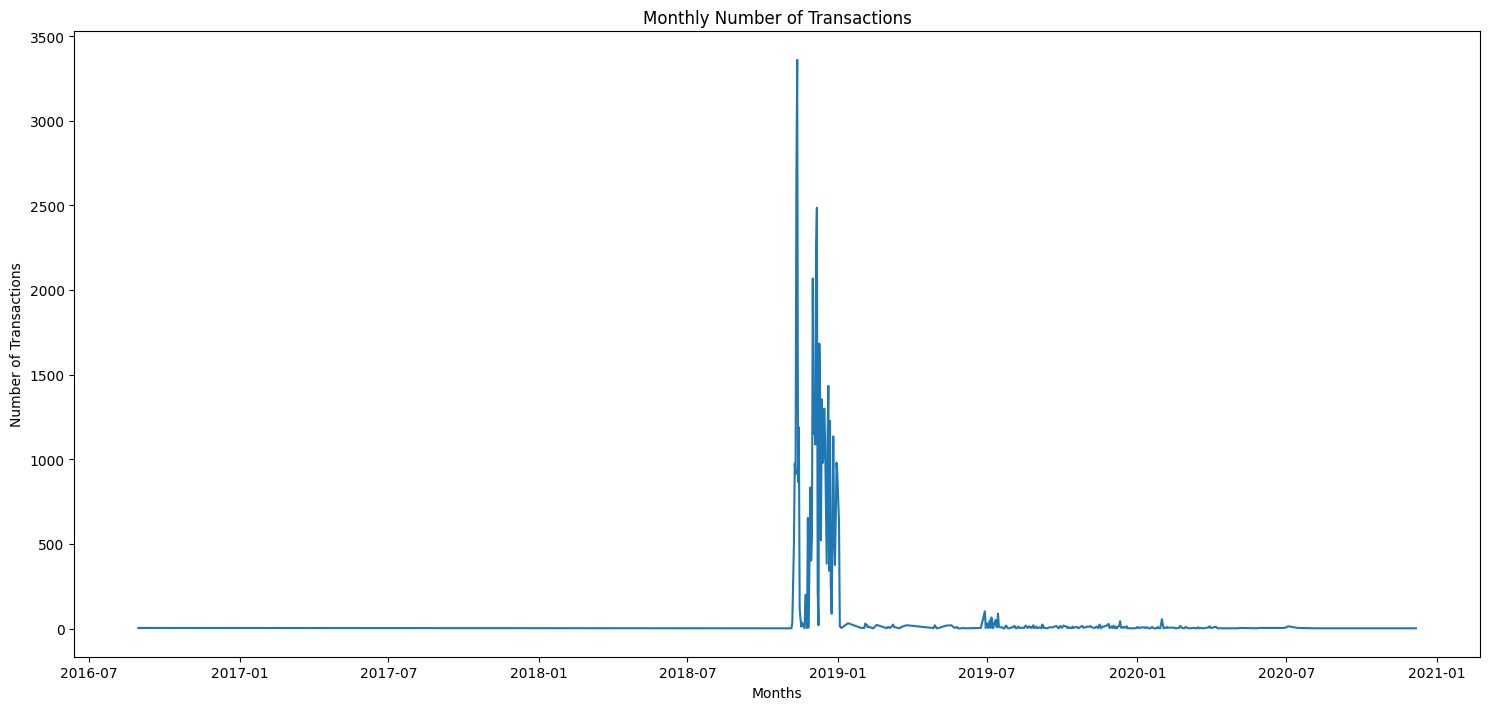

In [109]:
# Data Visulization

# create a line plot which describes the relationship between date and number of transactions happened 
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(ax=ax, x='date', y='number_of_transactions', data=date_tran)
plt.tight_layout()
plt.title("Monthly Number of Transactions")
plt.xlabel("Months")
plt.ylabel("Number of Transactions")
plt.show()


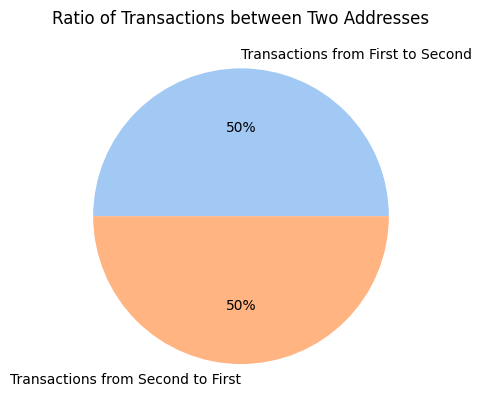

In [110]:
# create a pie chart which illustrates the ratio of transactions from opposite directions
tran_first_to_second = result['input_address'].value_counts()['1PPkPubRnK2ry9PPVW7HJiukqbSnWzXkbi']
tran_second_to_first = result['input_address'].value_counts()['19Kz98riwoFdTPnKe6s2Fg2xAEoa39rGg6']
tran_compare_lst = [tran_first_to_second, tran_second_to_first]
labels = ['Transactions from First to Second', 'Transactions from Second to First']
colors = sns.color_palette('pastel')[0:2]
plt.pie(tran_compare_lst, labels =labels, colors=colors, autopct='%.0f%%')
plt.title("Ratio of Transactions between Two Addresses")
plt.show()

In [111]:
# Summary of Analysis and Drived Insights

"""
During the analysis phase, we calculate various metrics (average,mean,median etc.) about the transactions and realize
the average is close to the min value. After inspection, we realize most transactions have a fixed value of 1000 
except four transactions with a value of 5757. We also notice the duration of interaction between two addresses ranges  
from 2016-08-30 to 2020-12-06. In addition, we find out most transactions happened between the end of 2018 and the 
beginning of 2019. In the visualization phase, the line plot proves that most transactions happened in a short period 
of time with significant fluctuations. Finally, the pie chart suggests an interesting fact that transactions from both
directions exactly equal, which means two wallets may belong to the same individual or organization.
"""


'\nDuring the analysis phase, we calculate various metrics (average,mean,median etc.) about the transactions and realize\nthe average is close to the min value. After inspection, we realize most transactions have a fixed value of 1000 \nexcept four transcations with a value of 5757. We also notice the duration of interaction between two addresses ranges from \n2016-08-30 to 2020-12-06. In additon, we find out most transactions happened between the end of 2018 and the \nbeginning of 2019. In the visulization phase, the line plot proves that most transactions happened in a short period \nof time with significant fluctuations. Finally, the pie chart suggests an intersting fact that transcations from both\ndirections exactly equal, which means two wallets may belong to the same individual or organization.\n\n'